# <p align="center"> Hotel Allocation Project </p> #
## <p align="right"> Alessandro Macchi - 53633A </p> ##

## <p> Introduction </p> ##

In this project, the focus is on optimizing hotel room allocation strategies to balance revenue generation, room occupancy, and guest satisfaction. Using datasets containing hotel information, guest preferences, and room pricing, we developed several allocation strategies. These strategies include random assignment, prioritizing guest preferences, assigning based on cost, and allocating according to room availability. The goal was to analyze which strategy most effectively maximizes hotel occupancy rates, optimizes customer satisfaction, and generates the highest revenue, while considering specific factors like discount rates.

### <p> Preliminary assumptions </p>

<p> Before presenting the project, several assumptions about its scope and structure must be clarified. This code is tailored specifically to the provided datasets, and certain conditions are deliberately ignored due to the nature of the data. The two primary assumptions are as follows: (I) each hotel and guest has a unique, codified name, and (II) guests have only expressed preferences for hotels included in the datasets. Checking these conditions programmatically would require additional code and controls that would unnecessarily slow down the project; therefore, they have been omitted. Recognizing these limitations is essential for a full understanding of the project. Additionally, it should be noted that guests may express preferences for certain hotels multiple times. However, due to the method implemented to handle preferences (which will be discussed shortly), this repetition does not impact the results.</p>

<p> At the start of each allocation, the datasets are reimported, and the DataFrames are restructured. This approach is intentional to ensure the independence of each strategy. This design allows users to allocate guests according to a specific criterion without running all the allocation strategies. By repeating these setup operations, each allocation strategy can function independently, providing results for the selected strategy without requiring the execution of the entire allocation code. </p>

### <p> Functions </p> ###

To enhance code organization and readability, the code has been modularized by grouping frequently used, user-defined functions into a separate folder (modules). This approach prevents redundancy by avoiding repeated blocks of similar code and promotes a cleaner, more efficient structure.

Before introducing the main functions and their characteristics, it is essential to ensure that the necessary libraries are imported.

In [75]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import streamlit as st
sys.path.append('C:/Users/Utente/Desktop/dse/1t/python_project/macchi_dse_hotel')

<p>The <font color="green">import_datasets()</font> function is responsible for loading all datasets required for the project.</p>

In [76]:
def import_datasets(base_path = "C:/Users/Utente/Desktop/dse/1t/python_project/Datasets/"):
    base_path = Path(base_path)
    
    hotel_df = pd.read_csv(base_path / "hotels.csv")
    guests_df = pd.read_csv(base_path / "guests.csv")
    priority_df = pd.read_csv(base_path / "preferences.csv")
    
    return hotel_df, guests_df, priority_df 

<p> The <font color="green">create_dataframes()</font> function is one of the more complex functions in the project. It restructures the three imported datasets by modifying column arrangements and relocating certain data elements. For example, guest preferences are incorporated as a list of hotels ordered by preference and linked to each guest in *guests_df*. While this structure simplifies some allocation tasks, it also impacts code efficiency. </p>
<p> The use of *list_of_preferences* instead of more sophisticated methods is driven by the speed of the process, as it outperforms other options in terms of efficiency. </p>

In [77]:
def create_dataframes(hotel_df, guests_df, priority_df):
    
    hotel_df = hotel_df.rename(columns = {'hotel': 'name'})
    hotel_df = hotel_df.rename(columns = {'rooms': 'initial_rooms'})
    hotel_df['final_rooms'] = hotel_df['initial_rooms']

    guests_df = guests_df.rename(columns={'guest': 'name'})
    guests_df['preferences'] = None 
    
    list_of_preferences = []
    i = 0
    for guest in guests_df['name']:
        temporary_list = []
        while i < len(priority_df) and priority_df['guest'][i] == guest:
            temporary_list.append(priority_df['hotel'][i])
            i += 1
        list_of_preferences.append(temporary_list)
    
    guests_df['preferences'] = list_of_preferences
    
    return hotel_df, guests_df, priority_df

The <font color="green">hotel_wise_allocation()</font> function was developed to address the similar requirements of the Price and Availability strategies, enabling the main allocation process to be standardized across both methods.

In [78]:
def hotel_wise_allocation(hotel_df, guests_df, assignment):
    for hotel_name, row in hotel_df.iterrows():
        # create a vector with the guests that have the hotel_name in their preferences
        guests_vector = guests_df[guests_df['preferences'].apply(lambda x: hotel_name in x)].index
        for guest_name in guests_vector:
            if row['final_rooms'] > 0 and guest_name not in assignment:
                assignment[guest_name] = hotel_name
                hotel_df.loc[hotel_name, 'final_rooms'] -= 1
            if hotel_df.loc[hotel_name, 'final_rooms'] <= 0:
                break
    
    return assignment

The <font color="green">number_of_customers_accommodated()</font> function calculates the total number of guests who have been assigned accommodations.



In [79]:
def number_of_customers_accommodated(assignment):
    assigned_guests = len(assignment)
    
    return assigned_guests

The <font color="green">number_of_rooms_occupied()</font> function calculates the total number of rooms that have been occupied, corresponding to the number of assigned guests. This calculation is performed using the NumPy library.

In [80]:
def number_of_rooms_occupied(hotel_df):
    initial_rooms = hotel_df['initial_rooms'].to_numpy()
    final_rooms = hotel_df['final_rooms'].to_numpy()
    occupied_rooms = np.sum(initial_rooms - final_rooms)
    
    return occupied_rooms

The <font color="green">number_of_different_hotels_occupied()</font> function determines the number of hotels that are fully booked by the end of the allocation process.

In [81]:
def number_of_different_hotels_occupied(hotel_df):
    full_hotels = 0
    for hotel in hotel_df.index:
        if hotel_df.loc[hotel, 'final_rooms'] == 0:
            full_hotels += 1
    
    return full_hotels

The <font color="green">hotel_earnings()</font> function generates a dictionary containing the earnings for each hotel.

In [82]:
def hotel_earnings(assignment, guests_df, hotel_df):
    hotel_revenue = {}
    for guest, hotel in assignment.items():
        discount = guests_df.loc[guest, 'discount']
        price = hotel_df.loc[hotel, 'price']
        revenue = price * (1 - discount)
        hotel_revenue[hotel] = hotel_revenue.get(hotel, 0) + revenue
        
    return hotel_revenue

The <font color="green">total_volume_of_business1()</font> function calculates the total revenue generated by all hotels, taking into account the discount applied to each guest.

In [83]:
def total_volume_of_business1(hotel_revenue):
    total_revenue = np.sum(hotel_revenue.values())
    
    return total_revenue

The <font color="green">customer_satisfaction_random()</font> function calculates customer satisfaction specifically for the random allocation strategy, addressing unique requirements such as verifying whether the assigned hotel is on each guest’s preference list. Although this function is used only once, it is stored separately for organizational purposes.

In [84]:
def customer_satisfaction_random(guests_df, assignment_random):
    total_satisfaction_random = float(0)
    for guest in guests_df.index:
        preference_position = 0
        hotel_pref = guests_df.loc[guest, 'preferences']
        if assignment_random[guest] in hotel_pref:
            for i, preferred_hotel in enumerate(hotel_pref):
                if preferred_hotel == assignment_random[guest]:
                    preference_position = i
                    break
            g_satisfaction = (len(hotel_pref) - preference_position) / len(hotel_pref)
        else:
            g_satisfaction = 0
        total_satisfaction_random += g_satisfaction

    average_satisfaction_random = total_satisfaction_random / len(guests_df)
    
    return average_satisfaction_random

The <font color="green">customer_satisfaction()</font> function calculates customer satisfaction for all other allocation strategies.

In [85]:
def customer_satisfaction(guests_df, assignment):
    total_satisfaction = float(0)
    for guest in guests_df.index:
        if guest in assignment.keys():
            preference_position = 0
            hotel_pref = guests_df.loc[guest, 'preferences']
            for i, preferred_hotel in enumerate(hotel_pref):
                if preferred_hotel == assignment[guest]:
                    preference_position = i
                    break
            g_satisfaction = (len(hotel_pref) - preference_position) / len(hotel_pref)
        else:
            g_satisfaction = 0
        total_satisfaction += g_satisfaction

    average_satisfaction = total_satisfaction / len(guests_df)
    
    return average_satisfaction

### <p>Plots</p>

Additional functions have been defined and stored in a separate file to generate graphs using the Matplotlib library.

The <font color="green"> plot_hotel_revenue() </font> function creates a bar plot to display the revenue for each hotel, illustrating the impact of sorting order on earnings, if any.

In [86]:
def plot_hotel_revenue(assignment, guests_df, hotel_df):
    hotel_revenue = {}
    for guest, hotel in assignment.items():
        discount = guests_df.loc[guest, 'discount']
        price = hotel_df.loc[hotel, 'price']
        revenue = price * (1 - discount)
        hotel_revenue[hotel] = hotel_revenue.get(hotel, 0) + revenue
    
    hotels = list(hotel_revenue.keys())
    revenues = list(hotel_revenue.values())
    
    plt.figure(figsize = (10, 6))
    plt.bar(hotels, revenues, color='skyblue')
    plt.xlabel('Hotels')
    plt.ylabel('Revenue')
    plt.title('Revenue by Hotel')
    plt.xticks([])
    plt.tight_layout()
    plt.show()

The <font color="green"> revenue_comparison_by_strategy() </font> function compares the total revenue generated by each allocation strategy, highlighting instances where the allocation approach benefits either the hotels or the guests.

In [87]:
def revenue_comparison_by_strategy(total_revenue_random, total_revenue_preferences, total_revenue_price, total_revenue_availability):
    strategies = ['Random', 'Preference', 'Price', 'Availability']
    revenues = [total_revenue_random, total_revenue_preferences, total_revenue_price, total_revenue_availability]

    plt.figure(figsize=(10, 6))
    plt.bar(strategies, revenues, color=['blue', 'green', 'orange', 'purple'])
    plt.title('Revenue Comparison by Strategy')
    plt.xlabel('Allocation Strategy')
    plt.ylabel('Total Revenue in €')
    plt.show()

The <font color="green"> customer_satisfaction_by_strategy() </font> function, similar to the previous plot, compares customer satisfaction across different allocation strategies.

In [88]:
def customer_satisfaction_by_strategy(average_satisfaction_random, average_satisfaction_preferences, average_satisfaction_price, average_satisfaction_availability):
    strategies = ['Random', 'Preference', 'Price', 'Availability']
    satisfaction = [average_satisfaction_random, average_satisfaction_preferences, average_satisfaction_price, average_satisfaction_availability]

    plt.figure(figsize = (10, 6))
    plt.bar(strategies, satisfaction, color = ['blue', 'green', 'orange', 'purple'])
    plt.title('Customer Satisfaction by Strategy')
    plt.xlabel('Allocation Strategy')
    plt.ylabel('Average Satisfaction')
    plt.ylim(0, 1)
    plt.show()

## <p> Random allocation </p> ##

<p> The function file (my_functions) is imported, and the DataFrames are created. </p>
For simplicity, the indices of both the hotel_df and guests_df are set to the respective names, as these are guaranteed to be unique and progressively ordered values.

In [89]:
import random
from modules.my_functions import *

hotel_df, guests_df, priority_df = import_datasets()
hotel_df, guests_df, priority_df = create_dataframes(hotel_df, guests_df, priority_df)
hotel_df.set_index('name', inplace = True)
guests_df.set_index('name', inplace = True)

This command sets a seed for the random extrapolation, ensuring that the results remain consistent across runs, even though the process involves randomness.

In [90]:
random.seed(6)

This is the core of the random allocation process: a dictionary is created with guests as the keys and the assigned hotels as the values. This dictionary will be used to calculate the results of the allocation.

In [91]:
assignment_random = {}
for guest in guests_df.index:
    assigned_hotel = None
    while assigned_hotel is None:
        chosen_hotel = random.choice(hotel_df.index)
        row = hotel_df.loc[chosen_hotel]
        if row['final_rooms'] > 0:
            assignment_random[guest] = chosen_hotel
            hotel_df.loc[chosen_hotel, 'final_rooms'] -= 1
            assigned_hotel = chosen_hotel

The requests for this allocation are computed, and the results are subsequently compared in the final report.

In [92]:
assigned_guests_random = number_of_customers_accommodated(assignment_random)

occupied_rooms_random = number_of_rooms_occupied(hotel_df)

full_hotels_random = number_of_different_hotels_occupied(hotel_df)

hotel_revenue_random = hotel_earnings(assignment_random, guests_df, hotel_df)
total_revenue_random = total_volume_of_business1(hotel_revenue_random)

# The random allocation has a specific function
average_satisfaction_random = customer_satisfaction_random(guests_df, assignment_random)

Plots can be generated using the Matplotlib library to compare results. The following illustrates the revenue for each hotel.

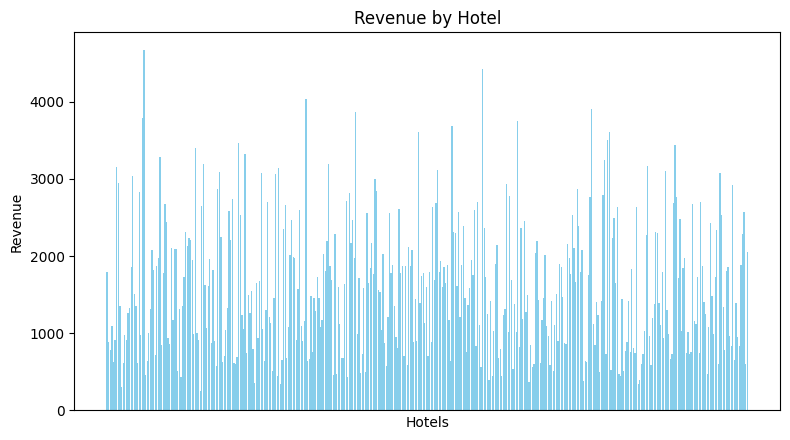

In [93]:
from modules.my_graphs import *

plot_hotel_revenue(assignment_random, guests_df, hotel_df)

The information extracted from this plot is limited due to the introduction of a randomness factor, which results in similar revenue figures across all hotels, with the exception of a few outlier values.

## <p> Preference allocation </p> ##

<p> The function file (my_functions) is imported, and the DataFrames are created. </p>
For simplicity, the indices of both the hotel_df and guests_df are set to the respective names, as these are guaranteed to be unique and progressively ordered values.

In [94]:
from modules.my_functions import *

hotel_df, guests_df, priority_df = import_datasets()
hotel_df, guests_df, priority_df = create_dataframes(hotel_df, guests_df, priority_df)
hotel_df.set_index('name', inplace = True)
guests_df.set_index('name', inplace = True)

This is the core of the preference allocation process: a dictionary is created with guests as the keys and the assigned hotels as the values. This dictionary will be used to calculate the results of the allocation.

In [95]:
assignment_preferences = {}
for guest in guests_df.index:
    preferences = guests_df.loc[guests_df.index == guest, 'preferences'].values[0]
    for chosen_hotel in preferences:
        row = hotel_df.loc[chosen_hotel]
        if row['final_rooms'] > 0:
            assignment_preferences[guest] = chosen_hotel
            hotel_df.loc[chosen_hotel, 'final_rooms'] -= 1
            break

The requests for this allocation are computed, and the results are subsequently compared in the final report.

In [96]:
assigned_guests_preferences = number_of_customers_accommodated(assignment_preferences)

occupied_rooms_preferences = number_of_rooms_occupied(hotel_df)

full_hotels_preferences = number_of_different_hotels_occupied(hotel_df)

hotel_revenue_preferences = hotel_earnings(assignment_preferences, guests_df, hotel_df)
total_revenue_preferences = total_volume_of_business1(hotel_revenue_preferences)

average_satisfaction_preferences = customer_satisfaction(guests_df, assignment_preferences)

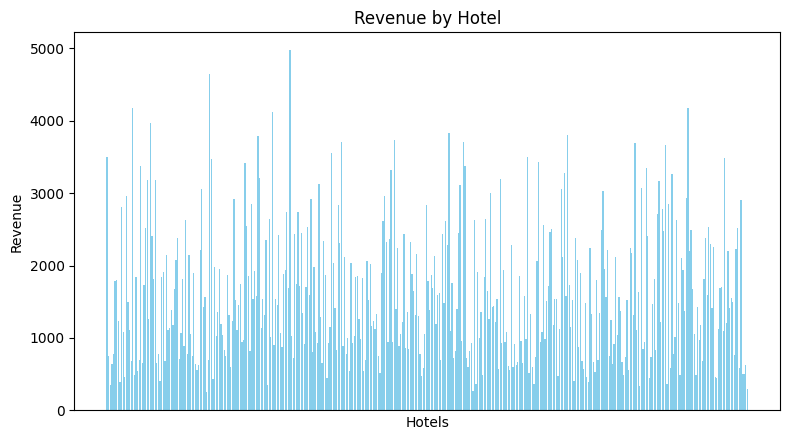

In [97]:
from modules.my_graphs import *

plot_hotel_revenue(assignment_preferences, guests_df, hotel_df)

Similar to the previous graph, there are no revenue-focused trends evident, and no particularly notable situations arise. It can, however, be inferred that some hotels have been preferred by guests, resulting in higher revenue for those establishments.

## <p> Price allocation </p> ##

The function file (my_functions) is imported, and the DataFrames are created. 

In [98]:
from modules.my_functions import *

hotel_df, guests_df, priority_df = import_datasets()
hotel_df, guests_df, priority_df = create_dataframes(hotel_df, guests_df, priority_df)

<p> The Price strategy prioritizes allocating guests to the cheaper hotels first. To achieve this, the <font color="green">sort_values()</font> function is used. </p>
For simplicity, the indices of both the hotel_df and guests_df are set to the respective names, as these are guaranteed to be unique and progressively ordered values.

In [99]:
hotel_df.sort_values(by = 'price', ascending = True, inplace = True)
hotel_df.set_index('name', inplace = True)
guests_df.set_index('name', inplace = True)

Using the previously introduced function <font color="green">hotel_wise_allocation()</font>, a dictionary is created with guests as the keys and the assigned hotels as the values. This dictionary will then be used to calculate the results of the allocation.

In [100]:
assignment_price = {}
assignment_price = hotel_wise_allocation(hotel_df, guests_df, assignment_price)

The requests for this allocation are computed, and the results are subsequently compared in the final report.

In [101]:
assigned_guests_price = number_of_customers_accommodated(assignment_price)

occupied_rooms_price = number_of_rooms_occupied(hotel_df)

full_hotels_price = number_of_different_hotels_occupied(hotel_df)

hotel_revenue_price = hotel_earnings(assignment_price, guests_df, hotel_df)
total_revenue_price = total_volume_of_business1(hotel_revenue_price)

average_satisfaction_price = customer_satisfaction(guests_df, assignment_price)

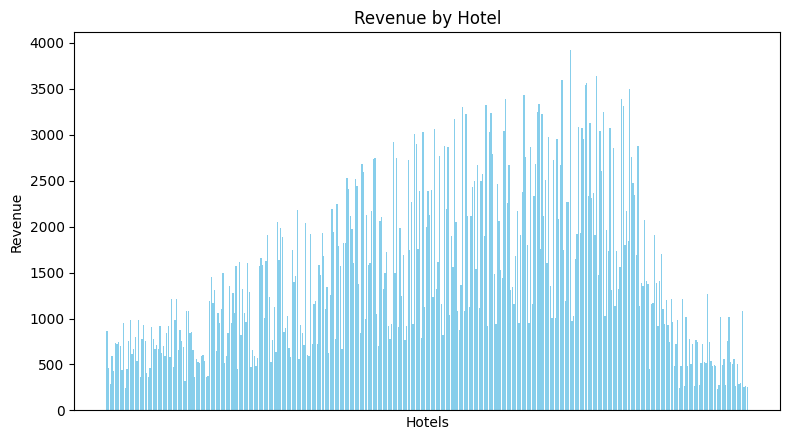

In [102]:
from modules.my_graphs import *

plot_hotel_revenue(assignment_price, guests_df, hotel_df)

This plot is arguably the most insightful of the series. As observed, the first hotels, which are likely to be fully booked due to the price-oriented allocation, exhibit minimal revenue. As we progress further, the hotels begin to generate higher revenue, reaching a point where there is a significant decline, indicating a sharp drop in demand. Beyond this point, many hotels experience zero bookings. From an economic perspective, this can be interpreted as a market equilibrium: if prices are set too high, demand diminishes.

## <p> Availability allocation </p> ##

The function file (my_functions) is imported, and the DataFrames are created.

In [103]:
from modules.my_functions import *

hotel_df, guests_df, priority_df = import_datasets()
hotel_df, guests_df, priority_df = create_dataframes(hotel_df, guests_df, priority_df)

<p> The Availability strategy prioritizes allocating guests to hotels with more rooms. To implement this, the <font color="green">sort_values()</font> function is used, which is the only difference between the code for price allocation and availability allocation. </p>
For simplicity, the indices of both the hotel_df and guests_df are set to the respective names, as these are guaranteed to be unique and progressively ordered values.

In [104]:
hotel_df.sort_values(by = 'initial_rooms', ascending = False, inplace = True)
hotel_df.set_index('name', inplace = True)
guests_df.set_index('name', inplace = True)

Using the previously introduced function <font color="green">hotel_wise_allocation()</font>, a dictionary is created with guests as the keys and the assigned hotels as the values. This dictionary will then be used to calculate the results of the allocation.

In [105]:
assignment_availability = {}
assignment_availability = hotel_wise_allocation(hotel_df, guests_df, assignment_availability)

The requests for this allocation are computed, and the results are subsequently compared in the final report.

In [106]:
assigned_guests_availability = number_of_customers_accommodated(assignment_availability)

occupied_rooms_availability = number_of_rooms_occupied(hotel_df)

full_hotels_availability = number_of_different_hotels_occupied(hotel_df)

hotel_revenue_availability = hotel_earnings(assignment_availability, guests_df, hotel_df)
total_revenue_availability = total_volume_of_business1(hotel_revenue_availability)

average_satisfaction_availability = customer_satisfaction(guests_df, assignment_availability)

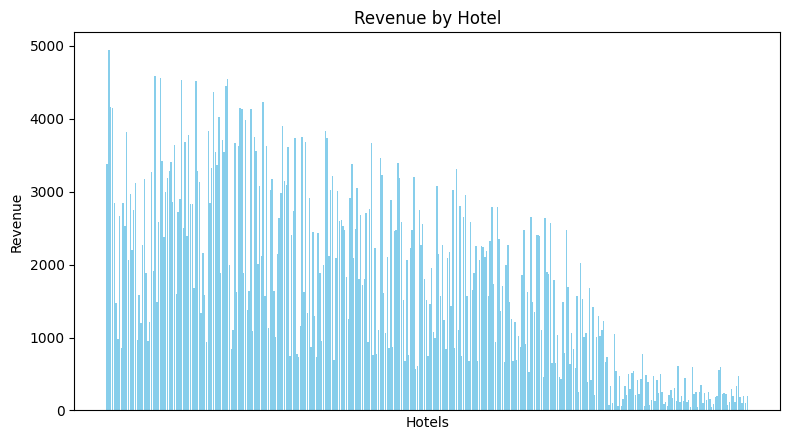

In [107]:
from modules.my_graphs import *

plot_hotel_revenue(assignment_availability, guests_df, hotel_df)

This plot illustrates the relationship between the number of available rooms and revenue. As anticipated, it is evident that hotels with a greater number of rooms tend to generate higher revenue. However, it is also observed that not all hotels with a high room availability achieve high revenue, which is likely linked to pricing strategies. Finding the optimal balance between price, room availability, and customer preferences is crucial for success.

## <p> Final report </p> ##

In [108]:
from tabulate import tabulate

allocation_results = [
    ["Random Strategy", assigned_guests_random, occupied_rooms_random, full_hotels_random, total_revenue_random, round(average_satisfaction_random, 3)],
    ["Preference Strategy", assigned_guests_preferences, occupied_rooms_preferences, full_hotels_preferences, total_revenue_preferences, round(average_satisfaction_preferences, 3)],
    ["Price Strategy", assigned_guests_price, occupied_rooms_price, full_hotels_price, total_revenue_price, round(average_satisfaction_price, 3)],
    ["Availability Strategy", assigned_guests_availability, occupied_rooms_availability, full_hotels_availability, total_revenue_availability, round(average_satisfaction_availability, 3)],
]

headers = ["Allocation Strategy", "Assigned Guests", "Occupied Rooms", "Hotels Fully Occupied", "Total Revenue", "Avg. Satisfaction"]
print(tabulate(allocation_results, headers=headers, tablefmt="grid"))

+-----------------------+-------------------+------------------+-------------------------+-----------------+---------------------+
| Allocation Strategy   |   Assigned Guests |   Occupied Rooms |   Hotels Fully Occupied |   Total Revenue |   Avg. Satisfaction |
+=======================+===================+==================+=========================+=================+=====================+
| Random Strategy       |              4000 |             4000 |                     246 |          637009 |               0.033 |
+-----------------------+-------------------+------------------+-------------------------+-----------------+---------------------+
| Preference Strategy   |              3975 |             3975 |                     255 |          643598 |               0.975 |
+-----------------------+-------------------+------------------+-------------------------+-----------------+---------------------+
| Price Strategy        |              3926 |             3926 |                   

Matplotlib can be used to generate graphs for analyzing the results.

As demonstrated in the following bar plot, the final revenues for each strategy are similar, with the exception of the price allocation strategy. Intuitively, this is understandable, as the primary objective of this strategy is to prioritize occupancy of cheaper hotels, which results in lower revenue.

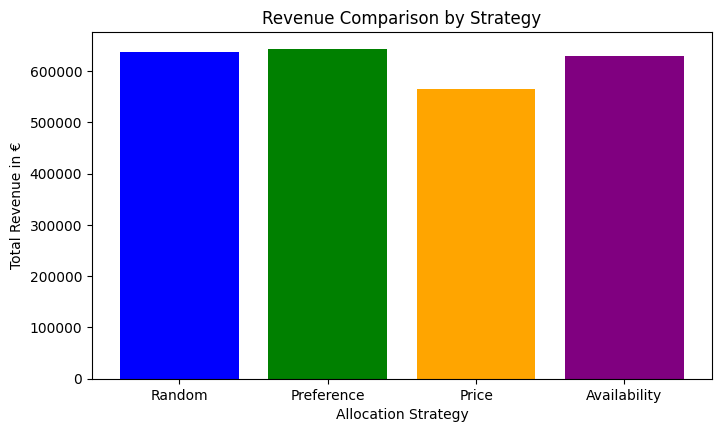

In [109]:
from modules.my_graphs import *

revenue_comparison_by_strategy(total_revenue_random, total_revenue_preferences, total_revenue_price, total_revenue_availability)

The second plot examines customer satisfaction. In a manner similar to the previous plot, the results align with expectations: when guest preferences are prioritized as the primary condition, customer satisfaction approaches 100%. Additionally, it is observed that when preferences are treated as a secondary condition, customer satisfaction remains around 50%, both in the price allocation and availability allocation strategies. In conclusion, the random strategy proves to be the least effective in this regard, as it may result in guests being assigned to hotels outside of their preference list.

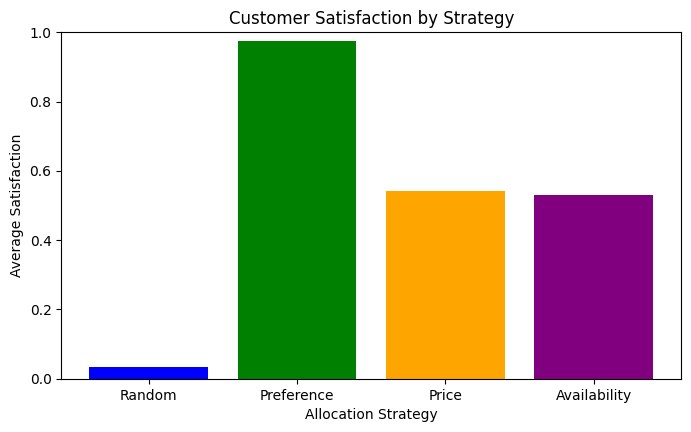

In [110]:
from modules.my_graphs import *

customer_satisfaction_by_strategy(average_satisfaction_random, average_satisfaction_preferences, average_satisfaction_price, average_satisfaction_availability)

## Streamlit Integration

After making minor adjustments to the various allocation processes to convert them into functions, a new file (*app_st.py*) was created to incorporate the required Streamlit code.  

Following the import of all necessary libraries, the code proceeds as outlined below.

In [111]:
import sys
import streamlit as st
import pandas as pd
from modules.my_functions import *
from stream_section.my_graph_st import *
from stream_section.all_allocations import *

sys.path.append('C:/Users/Utente/Desktop/dse/1t/python_project/macchi_dse_hotel')

hotel_df, guests_df, priority_df = import_datasets()
hotel_df, guests_df, priority_df = create_dataframes(hotel_df, guests_df, priority_df)

st.title("🏨 Hotel Allocation Strategies")

st.sidebar.header("Allocation Options")
strategy = st.sidebar.selectbox("Choose Allocation Strategy", ["Random", "Preferences", "Price", "Availability"])

if st.sidebar.button("Run Allocation"):
    if strategy == "Random":
        allocation, assigned_guests, occupied_rooms, full_hotels, total_revenue, average_satisfaction = allocate_random(guests_df, hotel_df)
    elif strategy == "Preferences":
        allocation, assigned_guests, occupied_rooms, full_hotels, total_revenue, average_satisfaction = allocate_preferences(guests_df, hotel_df)
    elif strategy == "Price":
        allocation, assigned_guests, occupied_rooms, full_hotels, total_revenue, average_satisfaction = allocate_by_price(guests_df, hotel_df)
    elif strategy == "Availability":
        allocation, assigned_guests, occupied_rooms, full_hotels, total_revenue, average_satisfaction = allocate_by_availability(guests_df, hotel_df)
    else:
        st.error("Invalid Strategy Selected")
        sys.exit()

    st.header(f"📋 Results for {strategy} Allocation")
    st.success("Allocation completed successfully!")

    st.subheader("📊 Key Metrics")
    col1, col2, col3 = st.columns(3)
    col1.metric("Guests Accommodated", f"{assigned_guests}")
    col2.metric("Rooms Occupied", f"{occupied_rooms}")
    col3.metric("Hotels Fully Occupied", f"{full_hotels}")

    col4, col5 = st.columns(2)
    col4.metric("Total Revenue", f"€{round(total_revenue, 2)}")
    col5.metric("Average Satisfaction", f"{round(average_satisfaction * 100, 2)}%")

    st.subheader("🛏️ Guest-Hotel Assignments")
    assignments_df = pd.DataFrame(list(allocation.items()), columns=["Guest", "Hotel"])
    st.dataframe(assignments_df.reset_index(drop = True))

    unassigned_guests = list(set(guests_df.index) - set(assignments_df["Guest"]))

    if unassigned_guests:
        st.warning(f"⚠️ {len(unassigned_guests)} Guests could not be assigned")
        unassigned_df = pd.DataFrame(unassigned_guests, columns=["Unassigned Guests"])
        st.dataframe(unassigned_df.reset_index(drop = True), height=200)
    else:
        st.success("🎉 All guests have been successfully assigned!")

    st.subheader("📈 Revenue Distribution by Hotel")
    plot_hotel_revenue(allocation, guests_df, hotel_df)


2024-11-18 18:38:20.459 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-18 18:38:20.460 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-18 18:38:20.461 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-18 18:38:20.461 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-18 18:38:20.463 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-18 18:38:20.464 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-18 18:38:20.465 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-18 18:38:20.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

<p> To review the results, the file *app_st.py* is opened via the terminal. </p>

 <p> Streamlit enhances the interactivity of the code, offering significant potential for expansion within this project. For example, it could enable users to upload their own lists of clients and hotels or customize the number of guests and hotels to be allocated, thereby avoiding hardcoded sections. </p>

<p> The possibilities with this library are vast. In this case, it is utilized to facilitate navigation through the results of the various allocation strategies, allowing users to explore the outcomes interactively. </p>

## <p> Conclusion </p> ##

Through the analysis of various allocation strategies, we gained insights about different approaches in maximizing both revenue and customer satisfaction. The strategies demonstrated that a preference-based approach not only enhance guest satisfaction, but it is also the best for revenue generation, reaching better results than the cost-based allocation even if not by a lot.